In [15]:
#http://d.hatena.ne.jp/naraba/20121201/p1
#http://web.mit.edu/music21/doc/usersGuide/usersGuide_01_installing.html

from music21 import *
#environment.set('musicxmlPath' , r"C:\Program Files (x86)\Finale NotePad 2012\Finale NotePad.exe")
#configure.run()
#environment.keys()
#environment.get('musicxmlPath')

楽譜を表示するためのおまじない
参考URL:https://groups.google.com/forum/#!topic/music21list/FmU6HeNm7AM

In [16]:
us = environment.UserSettings()
#us.create()
us['musicxmlPath'] = r'C:\Program Files (x86)\MuseScore 2\bin\MuseScore.exe'
us['musescoreDirectPNGPath'] = r'C:\Program Files (x86)\MuseScore 2\bin\MuseScore.exe'
%load_ext music21.ipython21

The music21.ipython21 extension is already loaded. To reload it, use:
  %reload_ext music21.ipython21


In [17]:
s_jazz = converter.parse('C:/Users/t/PycharmProjects/deepjazz_in_a_file/midi/original_metheny.mid')

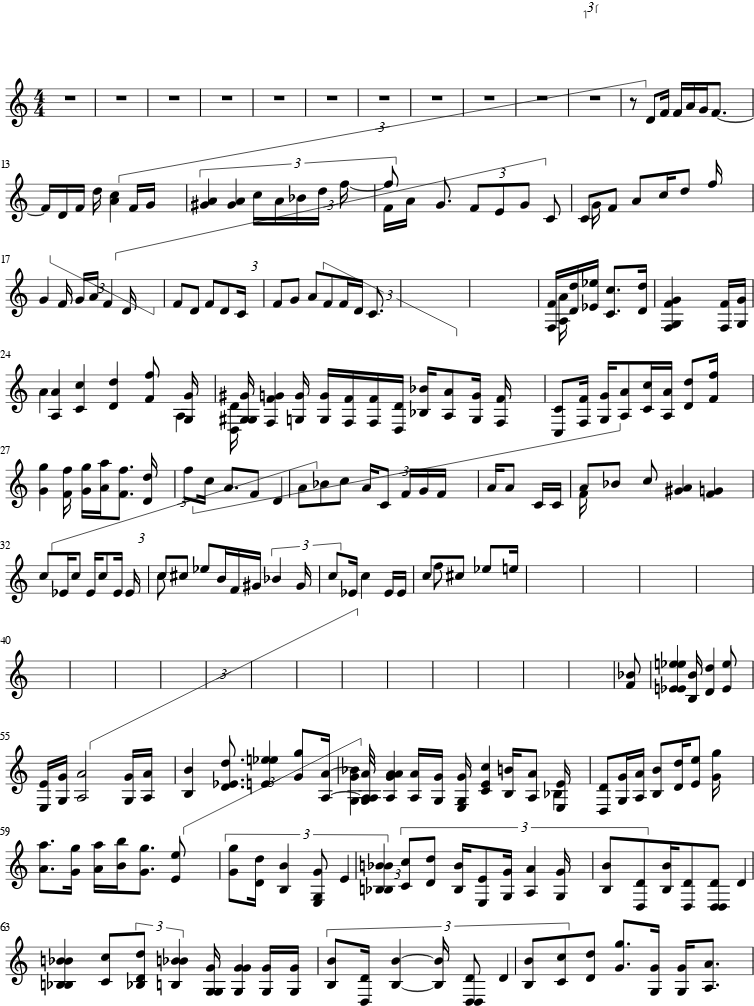

In [18]:
s_jazz[5].show()

midiでの演奏のさせ方：

In [19]:
sp = midi.realtime.StreamPlayer(s_jazz)
sp.play()

midi.base.py: WARNING: Conversion error for <MidiEvent PROGRAM_CHANGE, t=0, track=3, channel=3>: Got incorrect data for <MidiEvent PROGRAM_CHANGE, t=0, track=3, channel=3> in .data: None,cannot parse Program Change; ignored.
midi.base.py: WARNING: Conversion error for <MidiEvent PROGRAM_CHANGE, t=0, track=4, channel=3>: Got incorrect data for <MidiEvent PROGRAM_CHANGE, t=0, track=4, channel=3> in .data: None,cannot parse Program Change; ignored.
midi.base.py: WARNING: Conversion error for <MidiEvent PROGRAM_CHANGE, t=0, track=5, channel=3>: Got incorrect data for <MidiEvent PROGRAM_CHANGE, t=0, track=5, channel=3> in .data: None,cannot parse Program Change; ignored.
midi.base.py: WARNING: Conversion error for <MidiEvent PROGRAM_CHANGE, t=0, track=9, channel=3>: Got incorrect data for <MidiEvent PROGRAM_CHANGE, t=0, track=9, channel=3> in .data: None,cannot parse Program Change; ignored.
midi.base.py: WARNING: Conversion error for <MidiEvent PROGRAM_CHANGE, t=0, track=10, channel=3>: Go

KeyboardInterrupt: 

In [20]:
melody_stream = s_jazz[5]     # For Metheny piece, Melody is Part #5.
melody1, melody2 = melody_stream.getElementsByClass(stream.Voice)

voiceを複数持つパートをチェック：

In [22]:
[len(x.getElementsByClass(stream.Voice)) for x in s_jazz]

[5, 0, 4, 4, 0, 2, 4, 2, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0]

part 5はふたつのvoiceを持つ

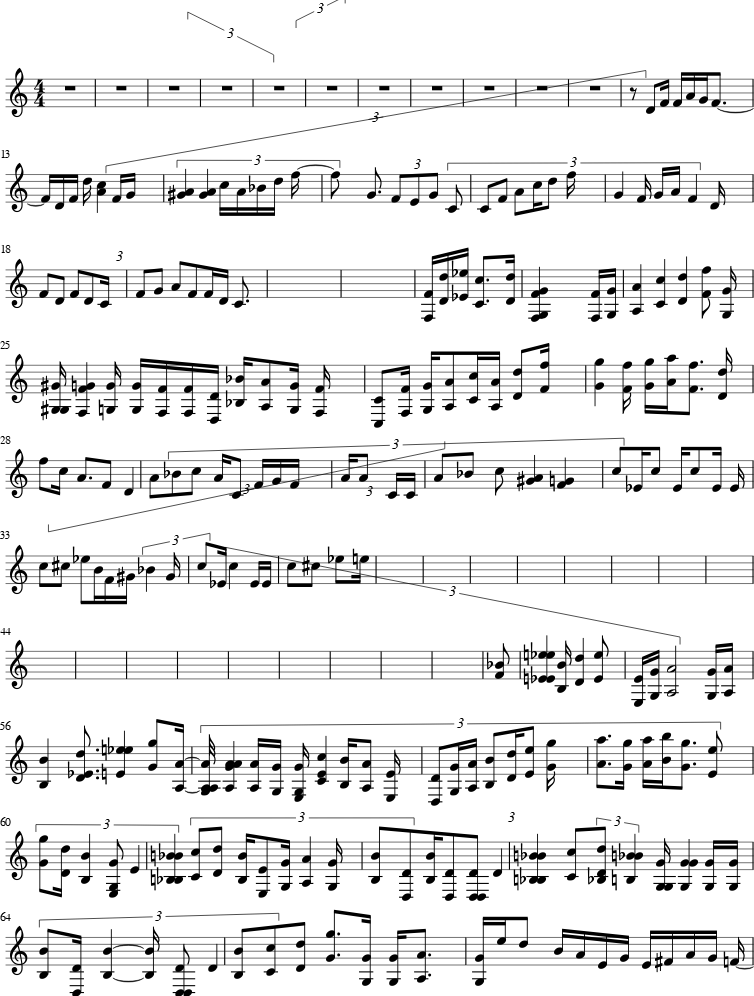

In [24]:
tmp_stream = stream.Score()
tmp_stream.insert(0 , melody1)
tmp_stream.show()

ふたつのvoiceをひとつにまとめてmelody_voiceに収納：

In [25]:
for j in melody2:
    melody1.insert(j.offset, j)

melody_voice = melody1 

melody_voiceに足りない部品を追加：

In [26]:
for i in melody_voice:
    if i.quarterLength == 0.0:
        i.quarterLength = 0.25

melody_voice.insert(0, instrument.ElectricGuitar())
#melody_voice.insert(0, key.KeySignature(sharps=1, mode='major'))
melody_voice.insert(0, key.KeySignature(1))

これを見るには：

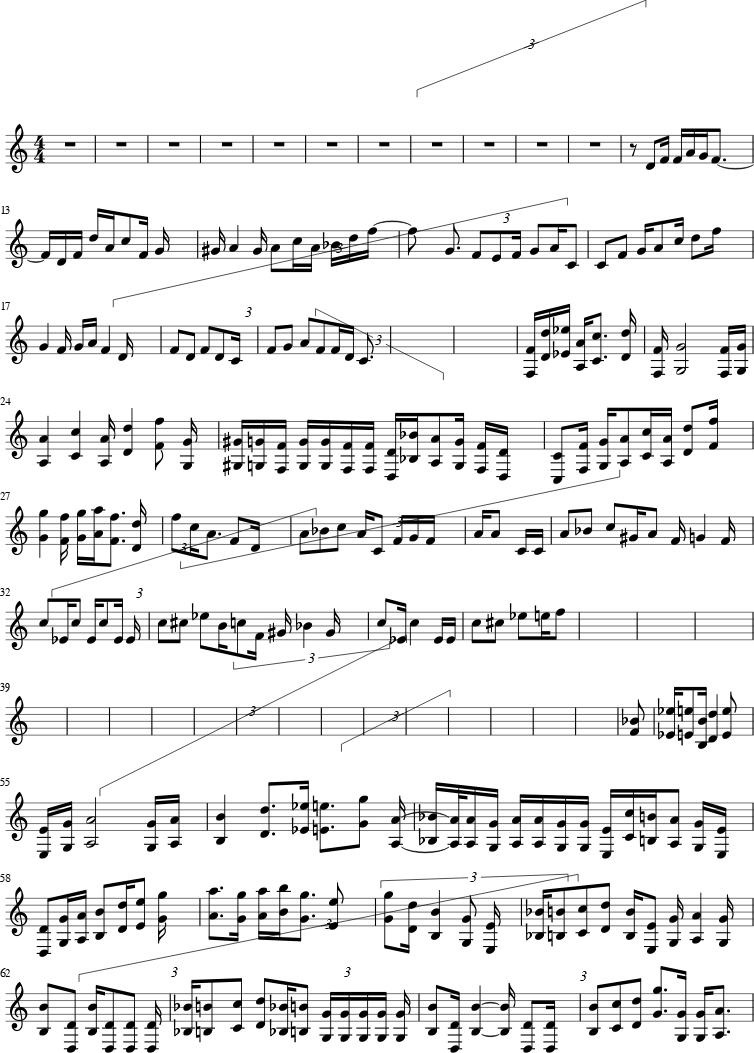

In [27]:
tmp_stream = stream.Score()
tmp_stream.insert(0 , melody_voice)
tmp_stream.show()

上記の代わりに以下ではだめ？？？==>だめっぽい

以下結構時間をかけたのちエラーが返る例：

In [11]:
tmp_stream = stream.Stream()
tmp_score = stream.Score()
tmp_voice = stream.Voice()
tmp_score.insert(melody_stream.flat)

tmp_score.show()

SitesException: v2.1. -- you may not assign an activesite for an object <music21.note.Note F> not in the Stream <music21.stream.Part 0xe98fd68_flat>

以下をやると後でエラーになる：

In [7]:
comp_stream = stream.Voice()
comp_stream.append([j.flat for i, j in enumerate(s_jazz) if i is not 5])

以下であればOK:

In [28]:
partIndices = [0, 1, 6, 7]
comp_stream = stream.Voice()
comp_stream.append([j.flat for i, j in enumerate(s_jazz) if i in partIndices])

以下２セルは同じようなことをやらせているつもり・・

In [17]:
full_stream = stream.Voice()

for i in range(len(comp_stream)):
    full_stream.append(comp_stream[i])

full_stream.append(melody_voice)

StreamException: the object (<music21.stream.Voice 0x7eea8d0>, id()=133081296) is already found in this Stream (<music21.stream.Voice 0x177a97b8>, id()=393910200)

In [29]:
full_stream = comp_stream
full_stream.append(melody_voice)

In [30]:
solo_stream = stream.Voice()
solo_start = 476
solo_end = 648#548

for part in full_stream:
    curr_part = stream.Part()
    curr_part.append(part.getElementsByClass(instrument.Instrument))
    curr_part.append(part.getElementsByClass(tempo.MetronomeMark))
    curr_part.append(part.getElementsByClass(key.KeySignature))
    curr_part.append(part.getElementsByClass(meter.TimeSignature))
    curr_part.append(part.getElementsByOffset(solo_start, solo_end,
                                              includeEndBoundary=True))
    cp = curr_part.flat
    solo_stream.insert(cp)


できたstreamは直接楽譜化できないので、scoreに加えてから見る：

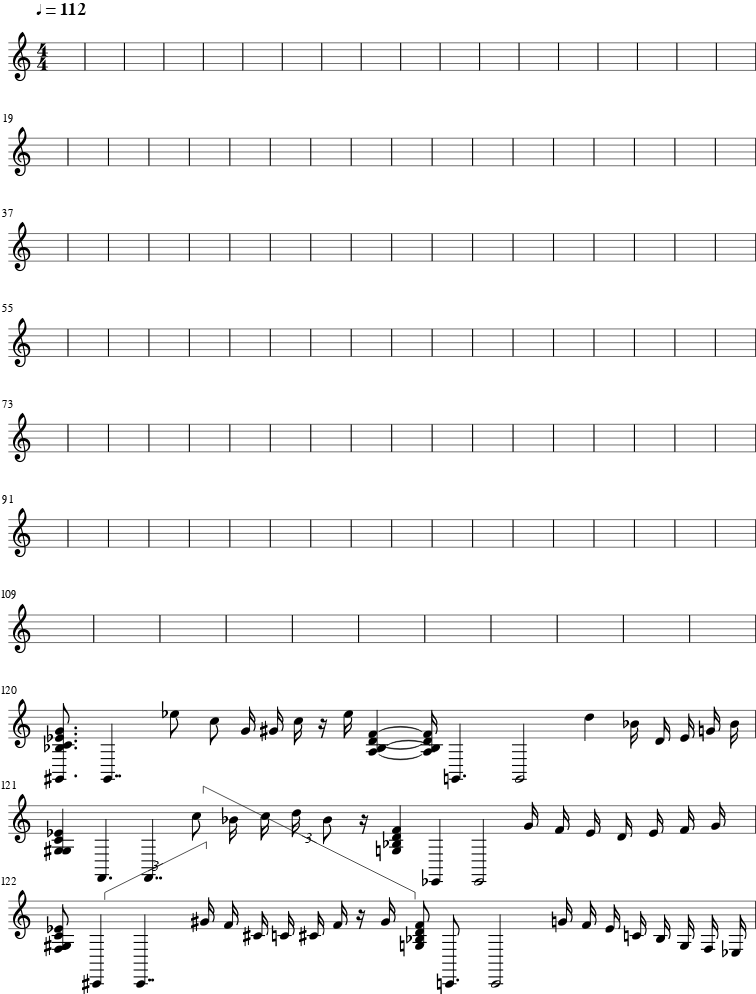

In [31]:
tmp_stream = stream.Score()
tmp_stream.insert(solo_stream)
#tmp_stream.insert(solo_start , solo_stream)
tmp_stream.show()

演奏させてチェック

In [ ]:
sp = midi.realtime.StreamPlayer(tmp_stream)
sp.play()

いろいろな楽器が含まれているsolo_streamから和音パートであるパート０のみ取り出す：

In [34]:
chordStream = solo_stream[0]

和音のみ取り出して
- 音に分解しnotesに格納
- offsetゼロからに詰める：

In [43]:
offsets = list()
notes = list()
for c in chordStream:
    if False:
        c = chordStream[2]
    if isinstance(c , chord.Chord):
        for p in c.pitches:
            if False:
                p = c.pitches[0]
            run_note = note.Note(p._getNameWithOctave())
           # run_note.volume.velocity = 200
            offsets.append(c.offset)
            notes.append(run_note)
run_sub = min(offsets)
offsets = [o - run_sub for o in offsets]
a_part = stream.Part()
for i, n in enumerate(notes):
    a_part.insert(offsets[i], n)


演奏させてチェック：

In [49]:
tmp_stream = stream.Score()
tmp_stream.insert(a_part)
sp = midi.realtime.StreamPlayer(tmp_stream)
sp.play()

楽譜はどうもうまく表示されない（同じoffsetの音がずれされて表示される？）:

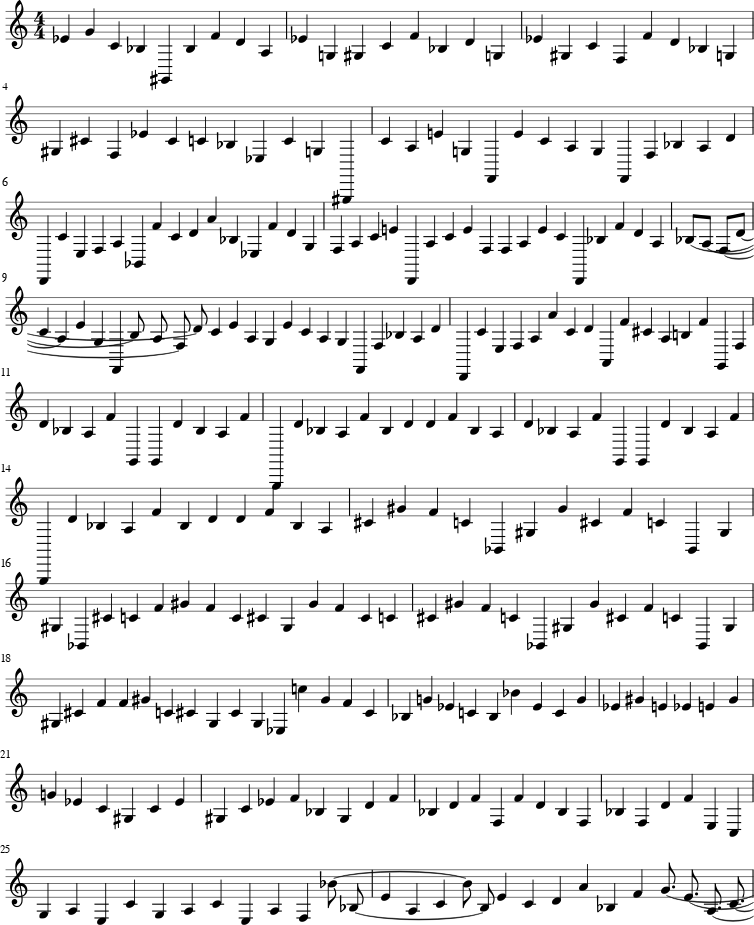

In [17]:
a_part.show()

# ランダム化メインパート

複数の楽器を指定して、それぞれに対応するパートを準備する：

In [ ]:
import numpy as np
N = 4

instruments = [instrument.ElectricGuitar() ,
               instrument.Piano() ,
               instrument.Cowbell() ,
               instrument.Flute()]
#instruments = [instrument.Flute() , instrument.Flute() , instrument.Flute() , instrument.Flute()]



multi_parts = [stream.Part() for i in range(N)]
for i in range(len(multi_parts)):
    #multi_parts[i].append(instruments[i])
    multi_parts[i].insert(instruments[i])

notesにある音を
- ランダムに全音上げる
- ランダムにvelocity（音量？）を変化させる
- ランダムに楽器パートに割り振る

In [ ]:
for i, n in enumerate(notes):
    j = np.random.randint(0 , N)
    #multi_parts[j].insert(offsets[i] + np.random.random() * 0.2 , n)
    #multi_parts[j].insert(offsets[i], n)
    if np.random.randint(0,2) == 1:
        n = n.transpose('m3')
    n.volume.velocity = 200 * (1 + np.random.random())
    multi_parts[j].insert(offsets[i] + float(np.random.randint(0, 2)) * 0.5, n)

In [13]:
run_score = stream.Score()
bpm = 180
run_score.insert(0.0, tempo.MetronomeMark(number=bpm))
#http://web.mit.edu/music21/doc/moduleReference/moduleStream.html
for i in range(len(multi_parts)):
    if False:
        i = 0
    run_score.insert(0 , multi_parts[i])

In [14]:
#run_score.show('midi')
sp = midi.realtime.StreamPlayer(run_score)
sp.play()

midi.base.py: WARNING: Conversion error for <MidiEvent PROGRAM_CHANGE, t=0, track=3, channel=3>: Got incorrect data for <MidiEvent PROGRAM_CHANGE, t=0, track=3, channel=3> in .data: None,cannot parse Program Change; ignored.


midi.base.py: WARNING: Conversion error for <MidiEvent PROGRAM_CHANGE, t=0, track=3, channel=3>: Got incorrect data for <MidiEvent PROGRAM_CHANGE, t=0, track=3, channel=3> in .data: None,cannot parse Program Change; ignored.


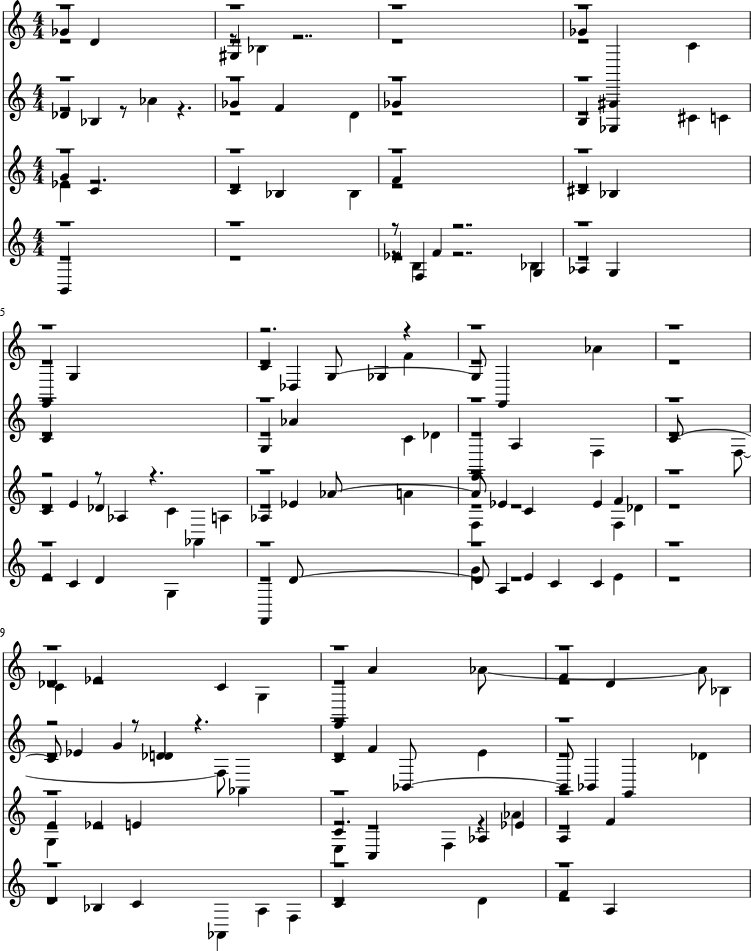

In [18]:
run_score.show()

### 以下素材

In [35]:
type(melody_stream)

music21.stream.Part

In [ ]:
type(melody1)

In [ ]:
type(melody1).mro()

In [ ]:
[x.offset for x in melody1.getElementsByClass(note.Note)]

In [ ]:
s_bach = corpus.parse('bach/bwv65.2.xml')

In [ ]:
len(s_bach)

In [ ]:
s_bach[1].show()
